# Setting up your environment

1. First, install `sentence-transformers`.


In [54]:
!pip install -U sentence-transformers


2. Copy the data folder to your own Google Drive, to be able to access it through colab: https://drive.google.com/drive/folders/1cZ8Lsu8r5QC-cHsD4FFrmFimN-HR_HKM

3. Mount your drive 


In [55]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline


Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


4. Adapt the path to point to the code and data folder within your Google Drive


In [56]:
DEMO_PATH = '/content/drive/MyDrive/Colab Notebooks/CovidTweets/'
import sys
sys.path.append(DEMO_PATH)

#from interactive import Interactive

5. Load the interactive class so that things are easier to handle later on

In [57]:
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import seaborn as sns


class Interactive(object):

  def __init__(self, tweet_text, tweet_embed):
    self.themes = {}
    self.theme_embeddings = {}
    self.model = SentenceTransformer('all-mpnet-base-v2')
    self.tweet_text = tweet_text
    self.tweet_embed = tweet_embed
    self.theme_tweet_dic = {}
    self.tweet2label = {}
    self.tweet2distance = {}

  def add_theme(self, theme, phrases=[]):
      if theme in self.themes:
        print('Error: theme already exists, remove it or update it.')
        return
      self.theme[theme] = phrases
      print('Theme {} succesfully added with the following phrases:'.format(theme))
      for phrase in self.themes[theme]:
        print('\t{}'.format(phrase))
      if len(phrases) > 0:
        self.recompute_theme_embeddings(theme)
        self.cluster_tweets()

  def update_theme(self, theme, phrases=[]):
    if theme not in self.themes:
      print('Theme {} does not exist, add it first by calling "add_theme(theme, phrases*)"')
    self.phrases[theme] += phrases
    if len(phrases) > 0:
      self.recompute_theme_embeddings(theme)
      self.cluster_tweets()

  def add_phrase(self, theme, phrase):
    if theme not in self.themes:
      print('Theme {} does not exist, add it first by calling "add_theme(theme, phrases*)"')
    self.phrases[theme].append(phrase)
    self.recompute_theme_embeddings(theme)
    self.cluster_tweets()

  def remove_phrase(self, theme, phrase):
    if theme not in self.themes:
      print('Theme {} does not exist, add it first by calling "add_theme(theme, phrases*)"')
    found = 0
    for _phrase in self.themes[theme]:
      if phrase.lower().strip() == _phrase.lower().strip():
        self.themes[theme].remove(_phrase)
        print('Removing "{}" for theme {}'.format(_phrase, theme))
        found = 1
    if not found:
      print('Phrase was not found, current phrases are:')
      self.show_phrases(theme)
    else:
      self.recompute_theme_embeddings(theme)
      self.cluster_tweets()
      


  def add_all(self, dictionary):
    for theme in dictionary:
      self.themes[theme] = dictionary[theme]
    self.recompute_all_embeddings()
    self.cluster_tweets()

  def recompute_theme_embeddings(self, theme):
    embeddings = []
    for phrase in self.themes[theme]:
      embeddings.append(model.encode([phrase])[0])
    self.theme_embeddings[theme] = embeddings

  def recompute_all_embeddings(self):
    for theme in self.themes:
      embeddings = []
      for phrase in self.themes[theme]:
        embeddings.append(self.model.encode([phrase])[0])
      self.theme_embeddings[theme] = embeddings

  def cluster_tweets(self):
    pbar = tqdm(total=len(self.tweet_text), desc='Re-clustering tweets')
    for j in range (0, len(self.tweet_text)): # all tweets
      min_dis = []; curr_themes = []
      for theme, val in self.themes.items(): #16 themes
        dis = []
        for i in range (0, len(val)): #phrases in each theme
          dis.append(distance.cdist(self.tweet_embed[j].reshape(1 , 768), self.theme_embeddings[theme][i].reshape(1 , 768), 'cosine'))
        min_dis.append(np.array(dis).min(axis=0).item())
        curr_themes.append(theme)

      min_index = np.array(min_dis).argmin(axis=0).item()
      min_dist = min_dis[min_index]
      theme = curr_themes[min_index]
    
      self.theme_tweet_dic.setdefault(theme, []) #add multiple values to same key dictionary 
      self.theme_tweet_dic[theme].append((min_dist, j))  #add multiple values to same key dictionary
      self.tweet2label[j] = theme
      self.tweet2distance[j] = min_dist
      pbar.update(1)

    # Sort them
    for theme in self.theme_tweet_dic:
      self.theme_tweet_dic[theme].sort()
    self.calculate_tfidf()

  def show_closest_tweets(self, theme, K):
    tweets = [(x[0], self.tweet_text[x[1]]) for x in self.theme_tweet_dic[theme][:K]]
    for tw in tweets:
      print(tw[0], tw[1])
      print('----')

  def calculate_tfidf(self):
    theme_docs = []
    themes = []

    K = 100
    for theme in self.theme_tweet_dic:  
      theme_tweets = [self.tweet_text[x[1]] for x in self.theme_tweet_dic[theme][:K]]
      all_text = " ".join(theme_tweets)
      themes.append(theme)
      theme_docs.append(all_text)
    vectorizer = TfidfVectorizer(max_df=0.7, ngram_range = (2,3))
    X = vectorizer.fit_transform(theme_docs)
    feature_names = vectorizer.get_feature_names()

    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    self.viz_data = df.transpose()
    self.viz_data.columns = themes

  def visualize_theme(self, theme):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(self.viz_data[theme])
    plt.imshow(wordcloud)

  def show_themes(self):
    for theme in self.themes:
      print(theme)

  def show_phrases(self, theme):
    for phrase in self.themes[theme]:
      print(phrase)
      print('----')

  def show_cluster_assignments(self, threshold=None):
    assigned = {}; 
    for k,v in self.theme_tweet_dic.items():
      if threshold is None:
        assigned[k] = len(v) 
      else:
        valid = [x for x in v if x[0] < threshold]
        assigned[k] = len(valid)
  
    f, ax = plt.subplots(figsize=(15,5)) # set the size that you'd like (width, height)
    plt.xticks(rotation=60)
    plt.bar(assigned.keys(), assigned.values(), label = 'Cluster assignnments')
    ax.legend(fontsize = 10)
    plt.savefig('assignments.png', dpi=300, bbox_inches = "tight") #will not chopped
    #self.show_silhouette_score(threshold)

  def show_silhouette_score(self, threshold=None):
    labels = [] #Index of the cluster each sample/tweet belongs to.
    X = [] # {array-like, sparse matrix} of shape (n_samples, n_features), for our case tweet embedding
    for tw in self.tweet2label:
      if threshold is None or self.tweet2distance[tw] < threshold:
        labels.append(self.tweet2label[tw])
        X.append(self.tweet_embed[tw])
   
    #print('Calculating silhouette score...')
    purity = metrics.silhouette_score(np.array(X),  np.array(labels), metric='euclidean')
    print("silhouette score: ", purity)
        
  def show_tsne(self, threshold=None):
    target = [] #Index of the cluster each sample/tweet belongs to.
    X = [] # {array-like, sparse matrix} of shape (n_samples, n_features), for our case tweet embedding
    for tw in self.tweet2label:
      if threshold is None or self.tweet2distance[tw] < threshold:
        target.append(self.tweet2label[tw])
        X.append(self.tweet_embed[tw])
    
    tSNE=TSNE(n_components=2, perplexity=40, n_iter=300)
    tSNE_result=tSNE.fit_transform(np.array(X))

    x=tSNE_result[:,0]
    y=tSNE_result[:,1]  

    df = pd.DataFrame(X)
    df['themes']=target
    df['x']=x
    df['y']=y

    #df 
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='x',y='y',hue='themes',palette=sns.color_palette("hls",df.themes.nunique()),data=df,
               legend="full")

    plt.savefig('tsne.png', dpi=300, bbox_inches = "tight") #will not chopped #rename fig based on threshold
    plt.show()


  

# Interacting with the Notebook


### First, we will load the preprocessed data and SBERT. Note that we are using a subset of the unlabeled data so that it fits in colab's memory


In [58]:
import os
import numpy as np

tweet_text = np.load(os.path.join(DEMO_PATH, "2021_US_vaccine_tweets_embed", "2021_US_tweets_text.npy"))
tweet_embed = np.load(os.path.join(DEMO_PATH, "2021_US_vaccine_tweets_embed", "2021_US_tweets_sbert.npy"))
print(tweet_text.shape, tweet_embed.shape)

interactive = Interactive(tweet_text, tweet_embed)

(85799,) (85799, 768)


### Set of initial themes based on paper

In [59]:
#themes are the key, and phrases are the values of the dictionary

phrases = {"govDistrust": ["lack of trust in the government"],
           "vaccineDanger": ["the vaccine will be dangerous to health"],
           "covidFake": ["COVID-19 disease does not exist or is not dangerous to health"], 
           "freedomChoice": ["I do not want to be vaccinated because I have freedom of choice"],
           "bigPharma": ["the vaccine was created only for the profit of pharmaceutical companies"],
           "naturalImunity": ["natural methods of protection against the disease are better than vaccines"],
           "vaccineWontWork": ["the vaccine does not exist or will not work"],
           "vaccineNotTested": ["the vaccine is not properly tested, it has been developed too quickly"],
           "vaccineExistedBefore": ["the vaccine has existed before the COVID-19 epidemic"],
           "noResponsibilityForSideEffects": ["no one is responsible for the potential side effects of the vaccine"],
           "conspiracyTheories": ["conspiracy theories, hidden vaccine effects (e.g., chips)"]
}

interactive.add_all(phrases)



Re-clustering tweets: 100%|██████████| 85799/85799 [00:32<00:00, 2663.37it/s]


### Explore tweets that are closest to the theme based on distance

In [60]:
interactive.show_closest_tweets('freedomChoice', K=10)

0.23707894090153303 @free_rover @AhBrightWings @OccupyDemocrats It’s not a choice if I’m medically exempt and my doctors ALL say that this vaccine is not recommended for me and many others with certain health conditions. Most people I know who have had COVID were all vaccinated and still ended up in the hospital.I have the right to be treated
----
0.238919463419063 Quite right. We have to have choice to make our own medical decisions. If you are worried about getting sick take the vaccine - you have that choice too. https://t.co/GKDPqeUwlN
----
0.2486658488533775 Freedom? No control? Sure! Let's give you freedom of choice. If you CHOOSE not to get the vaccine then you CHOOSE to accept no medical treatments for COVID symptoms! Simple
----
0.2519074511369087 I refuse the Covid vaccine because I will not have the government telling me, a woman, what to do with my body. Oops. Sorry for the moral quandary any of you may be drowning in right now 😁
----
0.25515369135482335 @shadeauxban @5000_

### Visualize themes

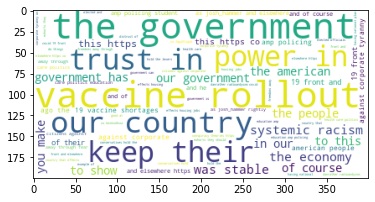

In [61]:
interactive.visualize_theme('govDistrust')

In [62]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories


### Show cluster assignments

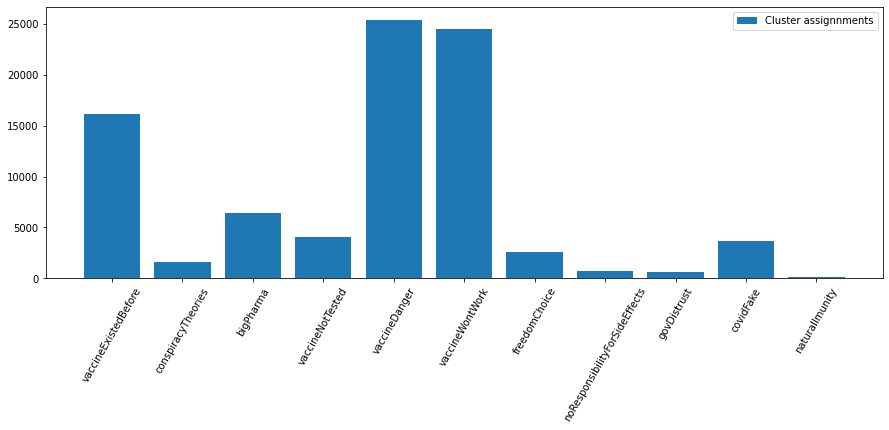

In [63]:
interactive.show_cluster_assignments()

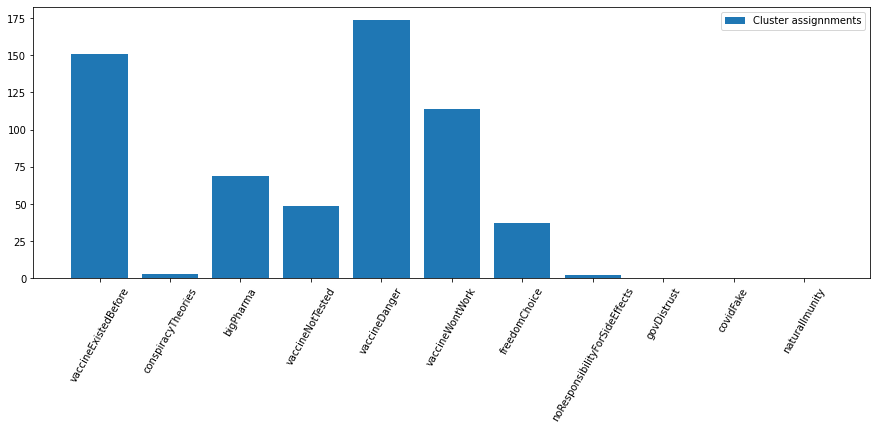

In [64]:
interactive.show_cluster_assignments(threshold=0.3)

In [65]:
interactive.show_silhouette_score(threshold=0.3)

silhouette score:  0.05392254


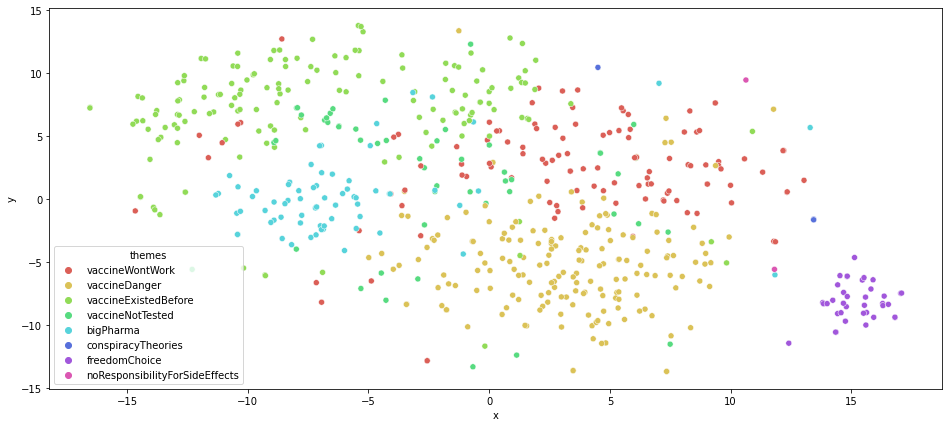

In [66]:
interactive.show_tsne(threshold=0.3)

In [67]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories


In [68]:
interactive.show_phrases('naturalImunity')

natural methods of protection against the disease are better than vaccines
----


In [69]:
phrases = {"govDistrust": ["lack of trust in the government"],
           "govTrust": ["we trust the government"],
           "bigPharmaAnti": ["the vaccine was created only for the profit of pharmaceutical companies"],
           "bigPharmaPro": ["I trust pharmaceutical companies"],
           "vaccineDanger": ["the vaccine will be dangerous to health"],
           "vaccineSaves": ["vaccine saves lives"],
           "freedomChoice": ["I do not want to be vaccinated because I have freedom of choice"],
           "vaccineNotOppression": ["the vaccine mandate is not oppression"],
           "vaccineAgainstReligion": ["the vaccine is against my religion"],
           "vaccineNotAgainstReligion": ["vaccine is not against any religion"],
           "covidFake": ["COVID-19 disease does not exist"], 
           "covidReal": ["COVID-19 is real"], 
           "naturalImunityPro": ["natural methods of protection against the disease are better than vaccines"],
           "naturalImunityAnti": ["natural immunity will not end the pandemic"],
           "vaccineWontWork": ["the vaccine does not work"],
           "vaccineWorks": ["the vaccine works"]
           
}

interactive.add_all(phrases)

Re-clustering tweets: 100%|██████████| 85799/85799 [01:00<00:00, 1411.70it/s]


In [70]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [71]:
interactive.show_closest_tweets('govDistrust', K=10)

0.43244792654931175 The credibility argument that Daniel Carpenter makes in this piece and @zeynep has made elsewhere really does run into this basic problem where it assumes administrative and political actors can actually predict what will increase trust https://t.co/Vo0bktu7K0 https://t.co/dyEOgMtwp5
----
0.5114455888265247 People say they don’t trust nor fuck with the government, then goes and gets a covid vaccine. What part of the game is that lol
----
0.5142686803414409 The government has a strong record of screwing things up.

https://t.co/1Q6Yj7oDjx
----
0.5184042180738356 @randykeel61 I think it is very healthy as an American voter to be constantly skeptical. But I would caution against never accepting anything the government does, because the government oversees good things too. Like the covid vaccine.
----
0.530252334912227 Just amazes me that people can look at the failures of government from local to state to federal levels, both regarding the COVID handling and now the va

In [72]:
interactive.show_closest_tweets('govTrust', K=10)

0.41721548100241257 The credibility argument that Daniel Carpenter makes in this piece and @zeynep has made elsewhere really does run into this basic problem where it assumes administrative and political actors can actually predict what will increase trust https://t.co/Vo0bktu7K0 https://t.co/dyEOgMtwp5
----
0.42362314628777564 @randykeel61 I think it is very healthy as an American voter to be constantly skeptical. But I would caution against never accepting anything the government does, because the government oversees good things too. Like the covid vaccine.
----
0.4459229598891108 The fact a lot of people don’t trust the Covid-19 vaccine because of the government, really speaks volumes about this country.
----
0.4712962569067505 Everyone I know who won't get the covid vaccine because they don't trust the government has sources that lead back to a politician. If you don't trust the government, I understand. However, trust the scientists.
----
0.478066305666465 The government has a str

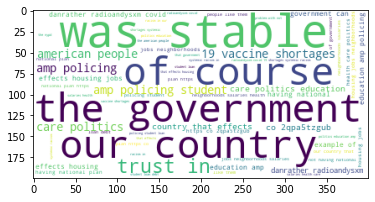

In [73]:
interactive.visualize_theme(theme='govDistrust')

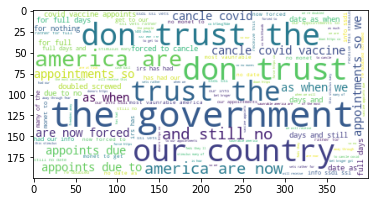

In [74]:
interactive.visualize_theme(theme='govTrust')

In [75]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [76]:
interactive.show_closest_tweets(theme='vaccineDanger', K=10)

0.2013119425594131 The vaccine that’s supposed to protect the most vulnerable is dangerous to the most vulnerable. 

Imagine that, the most harmful virus may turn out to be the vaccine. 

https://t.co/acaZXiKIZK
----
0.2013119425594131 The vaccine that’s supposed to protect the most vulnerable is dangerous to the most vulnerable. 

Imagine that, the most harmful virus may turn out to be the vaccine. 

https://t.co/acaZXiKIZK
----
0.2179735596263077 @RocktheMawk @thehill Dude,you are delusional! He'll be dead or someone with contact with him could be dead due to his false fears. Vaccines are safe. Safer than covid. I'd rather be a scientific first with a vaccine. Dont forget all the successes we've had in the past with vaccines. Science saves us
----
0.2179735596263077 @RocktheMawk @thehill Dude,you are delusional! He'll be dead or someone with contact with him could be dead due to his false fears. Vaccines are safe. Safer than covid. I'd rather be a scientific first with a vaccine. Don

In [77]:
interactive.show_closest_tweets(theme='vaccineSaves', K=10)

0.23592764778671416 The vaccine could save us, if we let it. Excellent piece about how we can stop Covid-19 spread in its tracks through actions by governments &amp; businesses, some Draconian, but necessary to protect our citizens, especially children.   https://t.co/yoPrijhKYt via @BostonGlobe
----
0.24381518005670821 The COVID vaccine saves lives. It’s safe, it’s free and it’s incredibly effective.

“More than 99% of COVID-19 deaths and 97% of hospitalizations are among people who have not been vaccinated, according to the CDC.”

https://t.co/wHO2CFII15
----
0.24381518005670821 The COVID vaccine saves lives. It’s safe, it’s free and it’s incredibly effective.

“More than 99% of COVID-19 deaths and 97% of hospitalizations are among people who have not been vaccinated, according to the CDC.”

https://t.co/wHO2CFII15
----
0.24898152316013444 What good does this vaccine do? Increased risk of getting COVID and no less risk of dying. https://t.co/u87JkpURhG
----
0.2545726418532558 “Any va

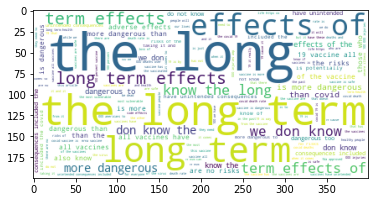

In [78]:
interactive.visualize_theme(theme='vaccineDanger')

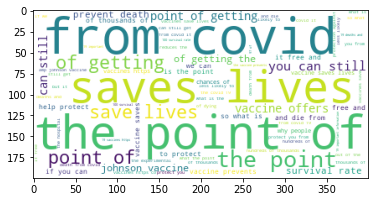

In [79]:
interactive.visualize_theme(theme='vaccineSaves')

In [80]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [81]:
interactive.show_closest_tweets(theme='covidFake', K=10)

0.3018066741298986 @JaredYamamoto There is no black and white. The CDC and other scientists are still learning about Covid. Deaths by Covid is preventable. You can't get a vaccine for avoiding a car crash.
----
0.30360438095828 Some doctor said that soon the  Covid-19 Virus will NOT dominate our lives--This virus never did dominate our lives--This pandemic was a lie inorder to give us that poisonous vaccine--!
----
0.3168731741778821 I AM NOT AN EXPERT IN COVID-19. there I said it. But I have still followed the science. We're over a year into this pandemic and a new, deadly variant is on the rise. You have to be fucking kidding me. We have a vaccine proven to be effective and safe.
----
0.320764743194633 So the COVID vaccine doesn’t prevent the spread of infection... just symptomatic disease.
----
0.3224282966363716 @TX_Cats_Rule Watching Faux News? Ever heard of SARS? COVID &amp; SARS belong to the same species of virus, coronavirus. Scientists have studied coronaviruses for over 50 y

In [82]:
interactive.show_closest_tweets(theme='covidReal', K=10)

0.15823256713402223 Yes, COVID-19 is real. We’ve been saying it for a year and a half now. Stop fucking around and go get the damn vaccine dummies. https://t.co/cN0cutQhbA
----
0.21038272136293557 It’s real! Let’s speak the truth about Covid-19. Take the vaccine if you have access, wear a mask, stay protected https://t.co/pnz9dgMLLy
----
0.21781502150481558 The pandemic is real. COVID-19 is real. The Delta Variant is real. All of these deaths are very real. Stop living with your head in the sand. Get the fucking vaccine. #COVID19 #DeltaVariant
----
0.22275565766730876 Covid is real. It is a virus not a conspiracy. There is a vaccine.  It is safe.  Millions of people have taken the vaccine.  They are alive and at home.  Please get the vaccine &amp; stay healthy &amp; keep your family healthy #COVID19
----
0.2301057374110601 I absolutely believe #Covid_19 is real. I'm not denying it.

I also believe in the science regarding viruses, immunology, epidemiology and biology.

What I don't bel

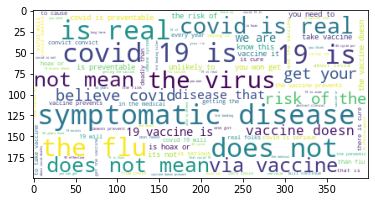

In [83]:
interactive.visualize_theme(theme='covidFake')

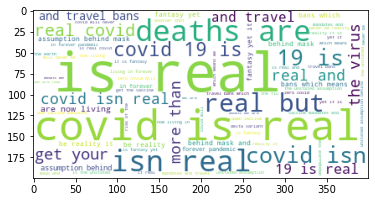

In [84]:
interactive.visualize_theme(theme='covidReal')

In [85]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [87]:
interactive.show_closest_tweets(theme='freedomChoice', K=10)

0.23707894090153303 @free_rover @AhBrightWings @OccupyDemocrats It’s not a choice if I’m medically exempt and my doctors ALL say that this vaccine is not recommended for me and many others with certain health conditions. Most people I know who have had COVID were all vaccinated and still ended up in the hospital.I have the right to be treated
----
0.23707894090153303 @free_rover @AhBrightWings @OccupyDemocrats It’s not a choice if I’m medically exempt and my doctors ALL say that this vaccine is not recommended for me and many others with certain health conditions. Most people I know who have had COVID were all vaccinated and still ended up in the hospital.I have the right to be treated
----
0.238919463419063 Quite right. We have to have choice to make our own medical decisions. If you are worried about getting sick take the vaccine - you have that choice too. https://t.co/GKDPqeUwlN
----
0.238919463419063 Quite right. We have to have choice to make our own medical decisions. If you are

In [88]:
interactive.show_closest_tweets('vaccineNotOppression', K=10)

0.23611887518454078 “Vaccine mandates present similar problems. Besides being flagrantly unconstitutional and a violation of bodily autonomy, these mandates ignore the natural immunity that millions of people have built up.” @HannahDCox #MandatoryVaccination #vaccine https://t.co/jdRdqzUuAa
----
0.27869120080261245 Regardless Of Union Deals
Or FOP Deals Or Any Bullshit
Court Ruling Or Precedent,
Forced or Mandated Vaccine
Or MandatedPharma Or 
Mandated Covid Testing
Is Unconstitutional &amp; Invasive
Against any Physical &amp; Individual
&amp; Spiritual &amp; Religious Autonomy
&amp; Freedom &amp; Security
----
0.2869392832029498 The ACLU explains why mandating vaccines is not a violation of your liberty rights. #vaccine #COVID 

https://t.co/LUgyHUF8uS
----
0.2912584073726402 @jobelewis @robsak72 @megbasham Fair enough. I’m still asking if it is only COVID vaccines mandates which or tyrannical, or ALL vaccine mandates which are tyrannical. You have now clarified Polio is not. Are ther

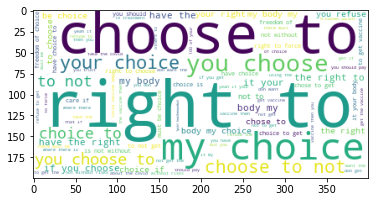

In [89]:
interactive.visualize_theme(theme='freedomChoice')

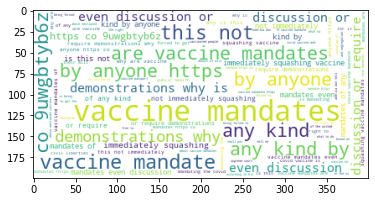

In [90]:
interactive.visualize_theme(theme='vaccineNotOppression')

In [91]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [95]:
interactive.show_closest_tweets(theme='bigPharmaPro', K=10)

0.369390549406876 I won't trust Johnson &amp; Johnson after knowing their baby powder caused cancer for decades than got sued. Not held accountable for people's lives than Trump gives them a contract to make a vaccine. Oh Hell no. https://t.co/2i8nWlrHbd
----
0.38810727668719036 @oni_blackstock @LadyDoctorSays Antivaxxers: You trust Pfizer for your Viagra..
Why not trust them for your Covid vaccine?
----
0.43645952082077044 Pfizer, AstraZeneca … or Both? A Mixed Approach May Hold Promise. https://t.co/sMQcbVFNj7
----
0.437090575681098 Johnson and Johnson makes shampoo how would you trust them with a New Covid Vaccine? Make it make sense….
----
0.46668866498539674 @mjansen22598292 @JRa_MKE @ClintThomason @TheFWAA You may need to understand,FDA is the group who gave it the, even emergency, approval.

https://t.co/g9W4rWArgG
----
0.4729402500049317 @khinnenkamp @jacobcabe Sorry, I don't take the opinion of a "pharmaceutical and medical device analyst" over pharmaceutical research 
https:/

In [96]:
interactive.show_closest_tweets(theme='bigPharma', K=10)

0.22511272625588963 lmao obviously this is untrue. vaccine makers have tapped every available manufacturer who can produce this vaccine. and capitalism encourages them to do so. why would they benefit from getting *less* product out?

https://t.co/5V1yeFUfYu https://t.co/7EZzvxEbDU
----
0.22511272625588963 lmao obviously this is untrue. vaccine makers have tapped every available manufacturer who can produce this vaccine. and capitalism encourages them to do so. why would they benefit from getting *less* product out?

https://t.co/5V1yeFUfYu https://t.co/7EZzvxEbDU
----
0.22536195618078703 @KempM88 @jakeshieldsajj Pharmaceutical companies are corrupt, you will get no argument from on that, but they want to make money, if the Covid vaccine was killing people class action lawsuit follow
----
0.22536195618078703 @KempM88 @jakeshieldsajj Pharmaceutical companies are corrupt, you will get no argument from on that, but they want to make money, if the Covid vaccine was killing people class act

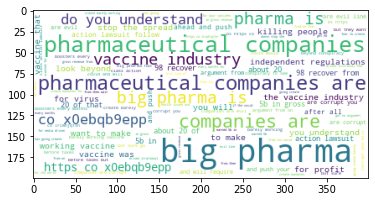

In [97]:
interactive.visualize_theme(theme='bigPharma')

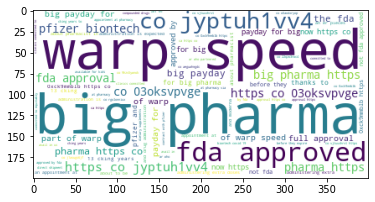

In [98]:
interactive.visualize_theme(theme='bigPharmaPro')

In [99]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [102]:
interactive.show_closest_tweets(theme='naturalImunityAnti', K=10)

0.24703826307519738 Why Vaccines Alone Will Not End the Pandemic https://t.co/7k4C0s0LO6
----
0.24707458240697855 Why Vaccines Alone Will Not End the Pandemic https://t.co/WS2lt0d0zV
----
0.24860806421345039 Why Vaccines Alone Will Not End the Pandemic https://t.co/Y9lnCtKbia
----
0.24885286415055208 Why Vaccines Alone Will Not End the Pandemic https://t.co/1B2NMEF9ab #COVID19 #pandemiclife
----
0.24941905998789138 Why Vaccines Alone Will Not End the Pandemic https://t.co/0Drhw5n3DN
----
0.25006250732317725 Why Vaccines Alone Will Not End the Pandemic https://t.co/I8L5MMmKEX
----
0.2547097973798921 Hospital covid cases in our region have fallen dramatically. We are close to population immunity. With the botched vaccine rollout here we will reach immunity naturally. @CDCDirector
----
0.26017975446529895 @celinegounder “evade immune responses to natural infection” 

I think this is misleading bc there are no proven reinfection deaths in the US for example. Immunity from infection or vacc

In [104]:
interactive.show_closest_tweets(theme='naturalImunity', K=10)

0.31314373275487783 @mrm09100 @JoeJoeskylove @jglennfl68 @carol823599 @justaguy1766 The only way you get “natural immunity” is to catch COVID.  That’s the old way of dealing with disease - ride it out and take the losses.  The invention of vaccines allowed us to defeat diseases WITHOUT all the death.  The DOCTORS say take the vaccine.  This isn’t hard.
----
0.31314373275487783 @mrm09100 @JoeJoeskylove @jglennfl68 @carol823599 @justaguy1766 The only way you get “natural immunity” is to catch COVID.  That’s the old way of dealing with disease - ride it out and take the losses.  The invention of vaccines allowed us to defeat diseases WITHOUT all the death.  The DOCTORS say take the vaccine.  This isn’t hard.
----
0.321739332195382 @DanCrenshawTX Natural immunity was recently studied... 6.7 times greater level of protection among those with natural immunity vs. those with vaxed immunity Requiring the vaccine in people who are already immune with natural immunity has no scientific support



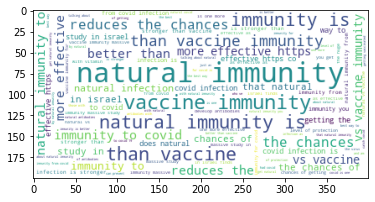

In [105]:
interactive.visualize_theme(theme='naturalImunity')

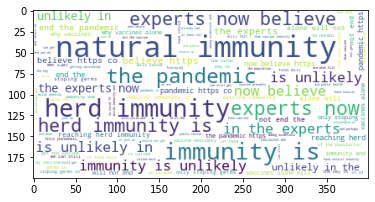

In [106]:
interactive.visualize_theme(theme='naturalImunityAnti')

In [107]:
interactive.show_themes()

govDistrust
vaccineDanger
covidFake
freedomChoice
bigPharma
naturalImunity
vaccineWontWork
vaccineNotTested
vaccineExistedBefore
noResponsibilityForSideEffects
conspiracyTheories
govTrust
bigPharmaAnti
bigPharmaPro
vaccineSaves
vaccineNotOppression
vaccineAgainstReligion
vaccineNotAgainstReligion
covidReal
naturalImunityPro
naturalImunityAnti
vaccineWorks


In [108]:
interactive.show_closest_tweets(theme='vaccineAgainstReligion', K=10)

0.12364607382425219 Taking the covid vaccine goes against my religion! period
----
0.20015223979717067 If you take a religious exception to the Covid vaccine, put your trust in god vs any medical services.  

Good luck with that.
----
0.20454123419939496 My belief is my belief. Do not force your vaccine on me. I have God on my side. He is greater than any vaccine or any virus. #Unvaccinated #unvaxxed #Covid_19 #DeltaVariant
----
0.2065657595954825 @EmacInSTL I am religious - very - and “religious” vaccine exemptions are bogus or “back-engineered” as @nytimes said today in their “COVID briefing.” https://t.co/WNcqzoYZaA
----
0.2252057619932144 Religious support for vaccines: https://t.co/6p4zPWqNkl
----
0.23880420188021123 I’ll say it, y’all “Christians” who are anti-Covid vaccine, where is your faith? Say a prayer, claim the blood of Jesus over yourself, and get vaccinated!
----
0.2436569347817017 I don’t believe in the vaccine. This is my choice. I put it ALL in God’s hands, because h

In [109]:
interactive.show_closest_tweets(theme='vaccineNotAgainstReligion', K=10)

0.2487067261846031 @KWaggonerADF @JennaEllisEsq @AllianceDefends @KariLake Other than Christian Scientists, what religion prohibits taking the COVID vaccine?
----
0.26351185891806606 Faith and the COVID vaccine: What religions have doctrinal reasons for being unvaccinated? #NewsBreak  https://t.co/K2R39Gl7Jh
----
0.26355788524868073 Curious. Which religions don't allow vaccines?  Also, if they allow the polio vaccine, why don't they allow the covid vaccine?  🤔
----
0.266515266102901 NO RELIGIOUS REASONS in Judeo-christian faith for NOT getting #vaccinated

There are only #charlatans
pushing their own agenda.

Mask-up.
Leviticus 13:45.
#GetVaccinated

"Citing religious beliefs to avoid the COVID-19 vaccine could cost you your job"  https://t.co/vtAEuPKgFf
----
0.2709135739656445 But that’s the problem Uber religious are forcing that only their thoughts and ideas of the rest of us but their disease from Covid vaccine rejection https://t.co/KhzlvPuGtG
----
0.27296129578402994 Every religi

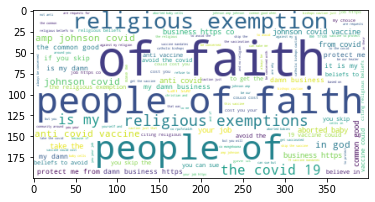

In [110]:
interactive.visualize_theme(theme='vaccineAgainstReligion')

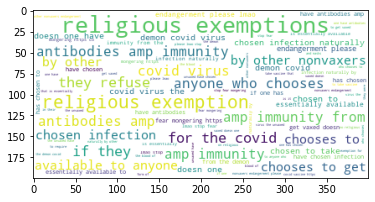

In [111]:
interactive.visualize_theme(theme='vaccineNotAgainstReligion')

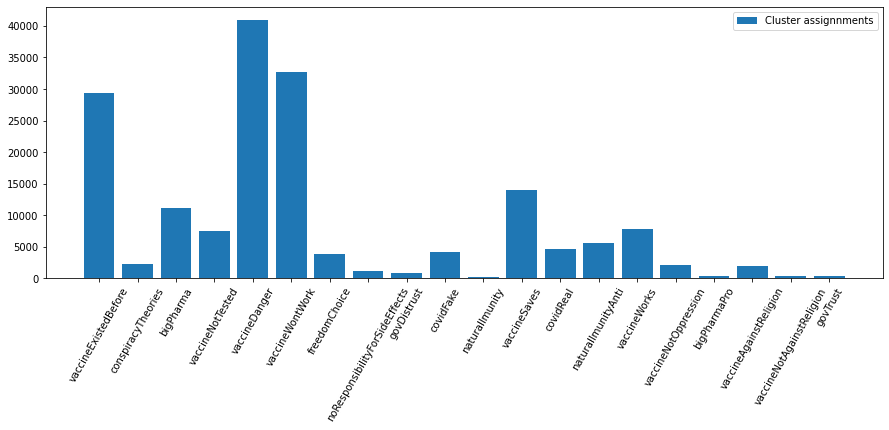

In [112]:
interactive.show_cluster_assignments()

In [114]:
interactive.show_closest_tweets(theme='vaccineWorks', K=10)

0.19606376193915942 I'm sure the vaccine magically started working.
https://t.co/pBJgx30goV
----
0.21673880410372248 Vaccines work! https://t.co/SgzhYXts2Z
----
0.22376651989170893 @DMAronoff @alicecthornton Thanks @DMAronoff and @alicecthornton 

The evidence is quite strong that vaccines are working quite well

https://t.co/4ksueW8mHR
----
0.24689310478814885 There’s no doubt vaccines work...but does this one? Covid numbers been going up since the vaccine came out 👀 https://t.co/BPmaRnNScP
----
0.24691783426343228 Vaccines work! And that’s why we’ll keep seeing vaccine mandates until we are all about to return to normal and manageable COVID risk https://t.co/lK3js70CK8
----
0.24721482140529516 @BetrCutlerLoose @eclipsethis2003 A few facts
1. It's not Trump's vaccine, it never should have been developed.
2. No it doesn't work, not for covid anyway.
----
0.2532533927579197 Ok vaccines work y'all...move it along plebs...you get the vaccine, you still get COVID anyway... https://t.co/ub2

In [115]:
interactive.show_closest_tweets(theme='vaccineWontWork', K=10)

0.1985465441642531 @_ChrisCurtis 
@KenLairdWEEI 
@jwiggs85 

The vaccine dont work. Lol

https://t.co/jemTlPiJeV
----
0.20241771639733774 Tell me the 'vaccine' doesn't work without telling me the 'vaccine' doesn't work https://t.co/mYERTHCnQg
----
0.21044544248484587 Oh boy 
As far as I see is that this vaccine does not work or at the very least it doesn't work anywhere close to the 98% they told everyone 
https://t.co/KvGcJhLxLu
----
0.2318914842633989 @HHSGov @samhsagov @SecBecerra I have no confidence in medical providers abilities in formulating a life saving vaccine.I am working on trauma therapy to reduce risk factors 4 underlying conditions risk factors contracting Covid Death from govt imposed education institutional child sexual exploitation1974-1987 https://t.co/Qbiog1Ulun
----
0.23417815574227052 But have issue with the Covid vaccine
----
0.23746751587471138 @vickieisthegoat @mjsalz @cara_jeffrey You need more information on the vaccine.  Try to understand…

https://t.co/SGD

In [119]:
interactive.show_closest_tweets(theme='vaccineNotTested', K=10)

0.16398444435498838 @alfio_durso @barnes_law Just like with Covid, those are more problems with the testing rather than the vaccine. The testing hasn’t come up-to-date with the technology.
----
0.16398444435498838 @alfio_durso @barnes_law Just like with Covid, those are more problems with the testing rather than the vaccine. The testing hasn’t come up-to-date with the technology.
----
0.24266037488058234 Dear Jenson, 

Research for the vaccine was started 20 years ago. You may never read this, buy someone will: https://t.co/zmfbS9hYOo https://t.co/9ygD1jZ8rG
----
0.24665249224497254 There is not enough study by taking the vaccine that it prevents the spread of Covid!!!????
----
0.24665249224497254 There is not enough study by taking the vaccine that it prevents the spread of Covid!!!????
----
0.24747588154037992 @ItsThatBriGuy is there a reason why? plenty of studies have been dedicated to this vaccine considering it is a pandemic. nothing short of other vaccines. mostly it's a funding